## Imports

In [1]:
import os
import cv2
import sys
import random
import warnings
import numpy as np 
import pandas as pd
from time import time
from itertools import chain
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
from skimage.transform import resize
from skimage.morphology import label
from skimage.io import imread, imshow, imread_collection, concatenate_images

import tensorflow as tf
from vit_keras import  vit, utils 
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import (
    Dense, Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, 
    Activation, Add, multiply, add, concatenate, LeakyReLU, ZeroPadding2D, UpSampling2D, 
    BatchNormalization, SeparableConv2D, Flatten )

from sklearn.metrics import classification_report
%matplotlib inline

In [2]:
MAIN_PATH = "E:/B21-CAP0443 Dataset/[Image - Classification] Tuberculosis (TB) Chest X-ray Database/TB_Chest_Radiography_Database/"

In [3]:
filenames = []
labels = []

for label in ['Tuberculosis', 'Normal']:
    for filename in os.listdir(MAIN_PATH + f'{label}/'):
        filenames.append(filename)
        labels.append(label)

data = pd.DataFrame({'filename':filenames, 'label':labels})
data.label = data.label.apply(lambda x: 0 if x=='Normal' else 1).astype(str)
data.label.value_counts()

1    3500
0    3500
Name: label, dtype: int64

## Split Dataset 

In [4]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

data = shuffle(data, random_state=42)

train_dt, val_dt, train_lb, val_lb = train_test_split(data.filename, data.label, stratify=data.label, test_size=0.2 ,random_state=0)
test_dt, val_test_dt, test_lb, val_test_lb = train_test_split(data[len(train_dt):].filename, data[len(train_dt):].label, test_size = 0.2, stratify = data[len(train_dt):].label, random_state=1)

print(len(train_dt))
print(len(val_test_dt))
print(len(test_dt))

5600
280
1120


In [6]:
train = data[:len(train_dt)]
val = data[len(train_dt):len(train_dt)+len(val_test_dt)]
test = data[-len(test_dt):]

In [10]:
train

,filename,label
6500,Normal-549.png,0
2944,Tuberculosis-499.png,1
2024,Tuberculosis-2820.png,1
263,Tuberculosis-1235.png,1
4350,Normal-1764.png,0
...,...,...
1279,Tuberculosis-215.png,1
6241,Normal-3466.png,0
6857,Normal-870.png,0
1555,Tuberculosis-2399.png,1


## Data Augmentation

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.25,
                             zoom_range=0.1,
                             rotation_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory=MAIN_PATH,
    x_col='filename',
    y_col='label',
    subset='training',
    batch_size=8,
    shuffle=True,
    class_mode='categorical',
    target_size=(224, 224)
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=val,
    directory=MAIN_PATH,
    x_col='filename',
    y_col='label',
    subset='validation',
    batch_size=8,
    shuffle=True,
    class_mode='categorical',
    target_size=(224, 224)
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=MAIN_PATH,
    x_col='filename',
    y_col=None,
    batch_size=8,
    shuffle=False,
    class_mode=None,
    target_size=(224, 224)
)

Found 4200 validated image filenames belonging to 2 classes.
Found 70 validated image filenames belonging to 2 classes.
Found 1120 validated image filenames.


## Callbacks

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss', factor=0.25, patience=3, verbose=1, mode='auto',
    min_delta=1e-10, cooldown=0, min_lr=0
)

early_stopping = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=9, verbose=1, mode='auto',
    baseline=None, restore_best_weights=True
)

ckpt = ModelCheckpoint(
    filepath = './saved_model/checkpoint/',
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True
)

callbacks = [reduce_learning_rate, early_stopping, ckpt]

## Model

In [14]:
image_size = 224

base_model = tf.keras.applications.ResNet50V2(
    input_shape=(image_size, image_size, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False
x = base_model.output
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [15]:
TRAINABLE_LAYERS= len(model.layers)-len(base_model.layers) + 5
print(TRAINABLE_LAYERS)
for layer in model.layers[:-TRAINABLE_LAYERS]:
    layer.trainable=False
for layer in model.layers[-TRAINABLE_LAYERS:]:
    layer.trainable=True

8


In [16]:
model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

## Train

In [18]:
history = model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=callbacks, verbose=1)

Epoch 1/50
525/525 [==============================] - 255s 452ms/step - loss: 0.3249 - accuracy: 0.8653 - val_loss: 0.0808 - val_accuracy: 0.9857
Epoch 2/50
525/525 [==============================] - 121s 231ms/step - loss: 0.1306 - accuracy: 0.9534 - val_loss: 0.1093 - val_accuracy: 0.9714
Epoch 3/50
525/525 [==============================] - 136s 259ms/step - loss: 0.0742 - accuracy: 0.9748 - val_loss: 0.0759 - val_accuracy: 0.9714
Epoch 4/50
525/525 [==============================] - 118s 224ms/step - loss: 0.0722 - accuracy: 0.9740 - val_loss: 0.0673 - val_accuracy: 0.9714
Epoch 5/50
525/525 [==============================] - 126s 240ms/step - loss: 0.0557 - accuracy: 0.9789 - val_loss: 0.1456 - val_accuracy: 0.9429
Epoch 6/50
525/525 [==============================] - 108s 205ms/step - loss: 0.0473 - accuracy: 0.9864 - val_loss: 0.0432 - val_accuracy: 1.0000
Epoch 7/50
525/525 [==============================] - 106s 202ms/step - loss: 0.0529 - accuracy: 0.9844 - val_loss: 0.0238 -

## Visualize

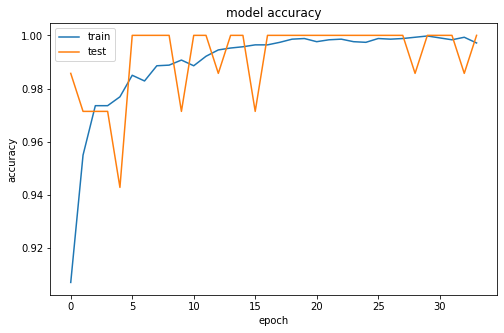

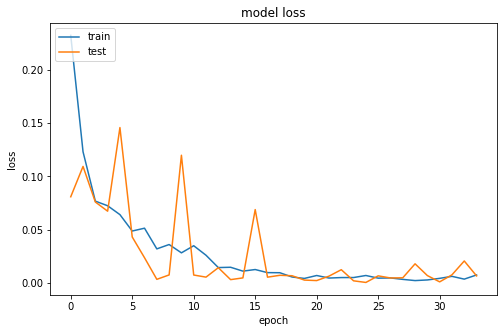

In [19]:
plt.figure(figsize=(8, 5))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=(8, 5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluate

In [20]:
model.evaluate(validation_generator, verbose=1)

9/9 [==============================] - 2s 227ms/step - loss: 0.0032 - accuracy: 1.0000


[0.0031569506973028183, 1.0]

In [21]:
y_pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred, axis = 1)

140/140 [==============================] - 41s 271ms/step


In [23]:
y_true = data[-len(test_dt):].label.values.astype(int)

In [24]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       563
           1       1.00      0.98      0.99       557

    accuracy                           0.99      1120
   macro avg       0.99      0.99      0.99      1120
weighted avg       0.99      0.99      0.99      1120



## Convert to TFLite

In [26]:
export_dir = 'saved_model/2'
tf.saved_model.save(model, export_dir=export_dir)

INFO:tensorflow:Assets written to: saved_model/2\assets


In [28]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

optimize="Speed"
if optimize=='Speed':
    converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
elif optimize=='Storage':
     converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
else:    
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()
open("resnet-tb.tflite", "wb").write(tflite_model)

27462608